# CNTK 104: Основы временных рядов Pandas and Finance Data

Contributed by: Avi Thaker
November 20, 2016

В этом учебнике будет представлено использование Cognitive Toolkit для данных временных рядов. Мы показываем, как подготовить данные временных рядов для алгоритмов глубокого обучения. Мы рассмотрим обучение нейронной сети и оценку модели нейронной сети. Мы также рассмотрим прогнозный потенциал по классификации Биржевых фондов ([ETF](https://en.wikipedia.org/wiki/Exchange-traded_fund)) и в этой упрощенной настройке, как можно торговать. Этот учебник служит **только**  в качестве примера того, как использовать нейронные сети для анализа временных рядов. 
    
Важно отметить, что фондовый рынок чрезвычайно шумный и его трудно предсказать. Это лучше всего делать профессионалам с опытом работы. Более важно убедиться, что модель правильная, прежде чем настраивать торговую систему (есть много факторов, которые следует учитывать, включая, но не ограничиваясь [смещение подгонки кривой](https://en.wikipedia.org/wiki/Overfitting), [прогнозный прогноз](http://www.investopedia.com/terms/l/lookaheadbias.asp?lgl=no-infinite), рентабельность и т. д.). Изучения и примеры, представленные в этом учебнике, предназначены только для примерных целей с целью введения подхода к анализу данных временных рядов.

В этом руководстве рассказывается, как использовать пакет pandas_datareader package и pandas. Обратите внимание, что в этом руководстве будет использоваться интерфейс numpy для CNTK, который хорошо взаимодействует с [Pandas dataframes](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) (структура, которая хорошо подходит для анализа временных рядов). 


In [1]:
from __future__ import print_function
import datetime
import numpy as np
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # ((требуется только для нашей системы сборки)
C.cntk_py.set_fixed_random_seed(1) #  перемешаем, чтобы примеры не повторялись

%matplotlib inline

ModuleNotFoundError: No module named 'cntk'

## Чтение данных
Сначала мы извлекаем данные запаса методом `get_stock_data`. Этот метод загружает данные о запасах по ежедневной шкале времени от Google Finance (может быть изменен для получения данных из Yahoo Finance и многих других источников). [Pandas datareader]( http://pandas-datareader.readthedocs.io/en/latest/remote_data.html)  показывает множество вариантов использования для чтения данных.

In [2]:
# Метод, который получает данные о запасах из Google finance
# Требуется подключение к Интернету для извлечения данных о запасах из Google

import time
try:
    from  pandas_datareader import data
except ImportError:
    !pip install pandas_datareader
    from  pandas_datareader import data 
    
# Установите случайное значение
np.random.seed(123)

def get_stock_data(contract, s_year, s_month, s_day, e_year, e_month, e_day):
    """
    Args:
        contract (str): the name of the stock/etf
        s_year (int): start year for data
        s_month (int): start month
        s_day (int): start day
        e_year (int): end year
        e_month (int): end month
        e_day (int): end day
    Returns:
        Pandas Dataframe: Daily OHLCV bars
    """
    start = datetime.datetime(s_year, s_month, s_day)
    end = datetime.datetime(e_year, e_month, e_day)
    
    retry_cnt, max_num_retry = 0, 3
    
    while(retry_cnt < max_num_retry):
        try:
            bars = data.DataReader(contract,"google", start, end)
            return bars
        except:
            retry_cnt += 1
            time.sleep(np.random.randint(1,10)) 
            
    print("Google Finance is not reachable")
    raise Exception('Google Finance is not reachable')

  Using cached pandas_datareader-0.5.0-py2.py3-none-any.whl
  Using cached requests-ftp-0.3.1.tar.gz
  Using cached requests-file-1.4.2.tar.gz
  Running setup.py bdist_wheel for requests-ftp: started
  Running setup.py bdist_wheel for requests-ftp: finished with status 'done'
  Stored in directory: C:\Users\Admin\AppData\Local\pip\Cache\wheels\76\fb\0d\1026eb562c34a4982dc9d39c9c582a734eefe7f0455f711deb
  Running setup.py bdist_wheel for requests-file: started
  Running setup.py bdist_wheel for requests-file: finished with status 'done'
  Stored in directory: C:\Users\Admin\AppData\Local\pip\Cache\wheels\3e\34\3a\c2e634ca7b545510c1b3b7d94dea084e5fdb5f33558f3c3a81
Successfully built requests-ftp requests-file


In [3]:
import pickle as  pkl

# Мы выполняем поиск в наборе данных кеширования с символом SPY.               
# роверьте переменную среды, определенную в тестовой инфраструктуре CNTK
envvar = 'CNTK_EXTERNAL_TESTDATA_SOURCE_DIRECTORY'
def is_test(): return envvar in os.environ

def download(data_file):
    try:
        data = get_stock_data("SPY", 2000, 1,2,2017,1,1)
    except:
        raise Exception("Data could not be downloaded")
        
    dir = os.path.dirname(data_file)
        
    if not os.path.exists(dir):
        os.makedirs(dir)
        
    if not os.path.isfile(data_file):
        print("Saving", data_file )
        with open(data_file, 'wb') as f:
            pkl.dump(data, f, protocol = 2)
    return data

data_file = os.path.join("data", "Stock", "stock_SPY.pkl")

# Проверка данных в локальном кеше
if os.path.exists(data_file):
        print("File already exists", data_file)
        data = pd.read_pickle(data_file) 
else: 
    # Если бы не мы могли работать в тестовой инфраструктуре CNTK
    if is_test():
        test_file = os.path.join(os.environ[envvar], 'Tutorials','data','stock','stock_SPY.pkl')
        if os.path.isfile(test_file):
            print("Reading data from test data directory")
            data = pd.read_pickle(test_file)
        else:
            print("Test data directory missing file", test_file)
            print("Downloading data from Google Finance")
            data = download(data_file)         
    else:
        # Локальный кеш отсутствует, а не тестовый конец загружает данные из
        # финансов Google и кэширует его в локальном каталоге
        # Пожалуйста, проверьте, есть ли данные торговли для выбранного символа акции в течение этого периода
        data = download(data_file)

Saving data\Stock\stock_SPY.pkl


## Функции сборки

Поведение на фондовом рынке демонстрирует существенную [автокорреляцию](https://en.wikipedia.org/wiki/Autocorrelation) ([reference](http://epchan.blogspot.com/2016/04/mean-reversion-momentum-and-volatility.html)). Мы используем индекс [ETF](http://www.investopedia.com/terms/e/etf.asp) `SPY` , представляющий «рынок» акций. Это ETF, который охватывает около 500 компаний в Америке по рыночной капитализации. Мы будем торговать в предположении, что существует некоторая краткосрочная автокорреляция, которая имеет прогностическую силу на рынке. 

**Цель**

* Будут ли следующие данные для данного фонда / ETF выше или ниже текущего дня.

**Возможности модели**

* Предыдущие 8 дней, классифицированные, если больше, чем текущий день,

* Объем изменяется в процентах,

* Процентное изменение от предыдущего дня.

Обратите внимание: мы не питаем нейросеть самой ценой. Данные финансового таймсерия являются шумными. Важно не перегружать данные. Здесь мы можем многое сделать (сглаживание, добавление дополнительных функций и т. Д.), Но мы сохраним этот учебник простым и продемонстрируем способность CNTK взаимодействовать с данными таймсеристов. 

In [4]:
# Список имен функций
predictor_names = []

# Вычислить разницу цен как функцию
data["diff"] = np.abs((data["Close"] - data["Close"].shift(1)) / data["Close"]).fillna(0)
predictor_names.append("diff")

# Вычислить разницу громкости как функцию
data["v_diff"] = np.abs((data["Volume"] - data["Volume"].shift(1)) / data["Volume"]).fillna(0)
predictor_names.append("v_diff")

# Вычислить запас вверх (1) или вниз (0) по разным дневным смещениям по сравнению с текущей ценой закрытия
num_days_back = 8

for i in range(1,num_days_back+1):
    data["p_" + str(i)] = np.where(data["Close"] > data["Close"].shift(i), 1, 0) # i: number of look back days
    predictor_names.append("p_" + str(i))

# Если вы хотите сохранить файл на локальном диске
# data.to_csv("PATH_TO_SAVE.csv")
data.head(10)

,Open,High,Low,Close,Volume,diff,v_diff,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8
Date,,,,,,,,,,,,,,,
2016-11-14,217.03,217.27,215.72,216.59,94579982,0.000000,0.000000,0,0,0,0,0,0,0,0
2016-11-15,217.04,218.28,216.80,218.28,91652580,0.007742,0.031940,1,0,0,0,0,0,0,0
2016-11-16,217.56,218.14,217.42,217.87,65617697,0.001882,0.396766,0,1,0,0,0,0,0,0
2016-11-17,218.05,219.06,217.92,218.99,69797191,0.005114,0.059881,1,1,1,0,0,0,0,0
2016-11-18,219.07,219.27,218.29,218.50,86265751,0.002243,0.190905,0,1,1,1,0,0,0,0
2016-11-21,219.17,220.18,219.00,220.15,72402638,0.007495,0.191472,1,1,1,1,1,0,0,0
2016-11-22,220.51,220.79,219.73,220.58,67428957,0.001949,0.073762,1,1,1,1,1,1,0,0
2016-11-23,219.98,220.76,219.75,220.70,56620237,0.000544,0.190899,1,1,1,1,1,1,1,0
2016-11-25,221.10,221.56,221.01,221.52,37872255,0.003702,0.495032,1,1,1,1,1,1,1,1


**Что пытается предсказать**

Здесь мы пытаемся предсказать, будет ли торговля следующих дней выше или ниже текущего дня. Мы будем представлять прогнозируемый день как 1, иначе 0, если следующий день будет таким же или ниже. (Примечание: рынок вряд ли будет закрываться по той же цене, что и в предыдущий день). 

In [5]:
data["next_day"] = np.where(data["Close"].shift(-1) > data["Close"], 1, 0)
data["next_day_opposite"] = np.where(data["next_day"]==1,0,1) # Метка должна быть закодирована

#Установите дату начала и окончания наших учебных периодов (выбрано за 2000 дней до краха рынка)
training_data = data["2001-02-05":"2009-01-20"] 

# Мы определяем наши тестовые данные как: data["2008-01-02":]
# Этот пример позволяет включать данные до текущей даты

test_data= data["2009-01-20":"2016-12-29"] 
training_features = np.asarray(training_data[predictor_names], dtype = "float32")
training_labels = np.asarray(training_data[["next_day","next_day_opposite"]], dtype="float32")

Здесь мы фактически создаем нейронную сеть. Мы будем использовать простую прямую нейронную сеть (представленную как `NN` на графиках) с 10 входами и 50 измерениями.

**Самостоятельная работа**Попробуйте экспериментировать здесь с разными размерами и количеством скрытых слоев. Что происходит, когда мы делаем эту сеть большой? Перерабатываем ли мы данные? 

In [6]:
print(training_features.shape)

(0, 10)


## Создание модели

Мы будем использовать простую сеть MLP в качестве нашей модели, используя библиотеку `layers`, найденную [здесь](https://cntk.ai/pythondocs/layerref.html).

In [7]:
# Давайте построим сеть
input_dim = 2 + num_days_back
num_output_classes = 2 # Помните, что нам нужно иметь 2, так как мы пытаемся классифицировать, идет ли рынок вверх или вниз 1 горячая кодировка
num_hidden_layers = 2
hidden_layers_dim = 2 + num_days_back
input_dynamic_axes = [C.Axis.default_batch_axis()]
input = C.input_variable(input_dim, dynamic_axes=input_dynamic_axes)
label = C.input_variable(num_output_classes, dynamic_axes=input_dynamic_axes)

def create_model(input, num_output_classes):
    h = input
    with C.layers.default_options(init = C.glorot_uniform()):
        for i in range(num_hidden_layers):
            h = C.layers.Dense(hidden_layers_dim, 
                               activation = C.relu)(h)
        r = C.layers.Dense(num_output_classes, activation=None)(h)   
    return r
    
z = create_model(input, num_output_classes)
loss = C.cross_entropy_with_softmax(z, label)
label_error = C.classification_error(z, label)
lr_per_minibatch = C.learning_rate_schedule(0.125,C.UnitType.minibatch)
trainer = C.Trainer(z, (loss, label_error), [C.sgd(z.parameters, lr=lr_per_minibatch)])

NameError: name 'C' is not defined

In [8]:
# Инициализируя параметры для тренера, мы будем тренироваться в больших minibatches в последовательном порядке
minibatch_size = 100
num_minibatches = len(training_data.index) // minibatch_size

# Запуск тренера и обучение модели
training_progress_output_freq = 1

# Визуализируйте потерю над minibatch
plotdata = {"batchsize":[], "loss":[], "error":[]}

## Обучение

**Заметка**: Количество проходов через данные, как мы обучаем данные временных рядов?

Этот учебник будет отличаться от других учебников в том смысле, что здесь мы не будем случайным образом отправлять данные тренеру, вместо этого каждый minibatch  будет последовательно передаваться в порядке измерения времени. Это ключ к обработке данных временных рядов, когда мы хотим «взвешивать» данные в конце нашего образца несколько выше. Вы можете сделать несколько проходов, однако вы заметите значительное снижение производительности. Попробуйте! Кроме того, многократные пропуски имеют тенденцию перегружать данные финансового таймера. Эта переоснащение может быть смягчена с использованием стандартных ML-подходов, таких как [L1 regularization](https://en.wikipedia.org/wiki/Regularization_%28mathematics%29).

In [9]:
tf = np.split(training_features,num_minibatches)

print("Number of mini batches")
print(len(tf))

print("The shape of the training feature minibatch")
print(tf[0].shape)

tl = np.split(training_labels, num_minibatches)

# Ключевым является то, что мы делаем только один проход через данные линейно по времени
num_passes = 1 

# Определяет утилиту, которая печатает ход обучения
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"
    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
    return mb, training_loss, eval_error

ZeroDivisionError: integer division or modulo by zero

In [10]:
# Обучите нашу нейронную сеть
tf = np.split(training_features,num_minibatches)
tl = np.split(training_labels, num_minibatches)

for i in range(num_minibatches*num_passes): # умножать на 
    features = np.ascontiguousarray(tf[i%num_minibatches])
    labels = np.ascontiguousarray(tl[i%num_minibatches])
    
    # Укажите сопоставление входных переменных в модели с фактическими данными minibatch , которые будут обучены с помощью
    trainer.train_minibatch({input : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

ZeroDivisionError: integer division or modulo by zero

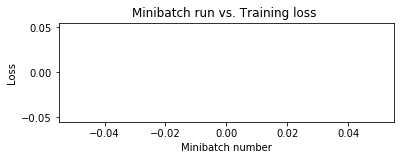

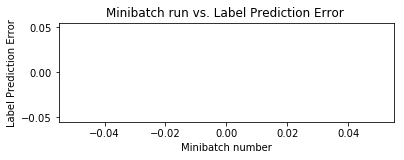

In [11]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["loss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss ')
plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["error"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error ')
plt.show()

Обратите внимание, что тренд ошибки прогноза метки по-прежнему близок к 50%. Помните, что это вариант времени, поэтому ожидается, что система будет иметь некоторый шум, когда он будет тренироваться во времени. Следует отметить; модель все еще изучает рынок. Кроме того, поскольку данные временных рядов настолько шумны, вероятность ошибок ниже 50% хороша (многие торговые фирмы имеют выигрышные ставки около 50% и зарабатывают почти каждый день [VIRTU](https://en.wikipedia.org/wiki/Virtu_Financial#Trading_activity)). Однако имейте в виду, что они являются высокочастотной торговой фирмой и могут использовать свои стратегии с низким уровнем выигрышей (51%). Попытка классифицировать и торговать каждый день дороже с точки зрения транзакционных сборов. Таким образом, один подход будет заключаться в торговле, когда мы думаем, что мы с большей вероятностью победим?

Попробуем эту идею.

In [12]:
# Теперь, когда мы обучили сеть, мы проведем пробный тест, чтобы узнать, как мы это сделали
# , а затем более важно проанализировать этот набор

test_features = np.ascontiguousarray(test_data[predictor_names], dtype = "float32")
test_labels = np.ascontiguousarray(test_data[["next_day","next_day_opposite"]], dtype="float32")

avg_error = trainer.test_minibatch({input : test_features, label : test_labels})
print("Average error: {0:2.2f}%".format(avg_error * 100))

NameError: name 'trainer' is not defined

Здесь мы видим, что частота ошибок составляет около 50%. На первый взгляд это может показаться не узнанным в сети, но давайте рассмотрим дальше и посмотрим, есть ли у нас некоторая интеллектуальная сила.

In [13]:
out = C.softmax(z)
predicted_label_prob = out.eval({input:test_features})
test_data["p_up"] = pd.Series(predicted_label_prob[:,0], index = test_data.index)
test_data["p_down"] = predicted_label_prob[:,1]
test_data['long_entries'] = np.where((test_data.p_up > 0.55), 1, 0)
test_data['short_entries'] = np.where((test_data.p_down > 0.55) , -1, 0)
test_data['positions'] = test_data['long_entries'].fillna(0) + test_data['short_entries'].fillna(0)

NameError: name 'C' is not defined

## Оценка
Здесь мы берем вывод нашего тестового набора и вычисляем вероятности из функции softmax. Поскольку у нас есть вероятности, мы хотим торговать, когда есть «более высокий» шанс, что мы будем правы, а не только> 50% шанс, что рынок пойдет в одном направлении. Цель состоит в том, чтобы найти сигнал, а не пытаться классифицировать рынок. Поскольку рынок настолько шумный, мы хотим торговать только тогда, когда у нас есть «край» на рынке. Кроме того, торговля часто имеет более высокую плату (вам приходится платить каждый раз, когда вы торгуете).

Будем говорить, что если вероятность прогнозирования превышает 55% (в любом направлении), мы будем занимать позицию на рынке. Если это покажет, что рынок будет на следующий день с вероятностью более 55%, мы займем 1 день. Если это больше, чем 55% вероятность того, что на следующий день будет ниже сегодняшней позиции, мы возьмем 1-дневный [short] (http://www.investopedia.com/university/shortselling/shortselling1.asp)(такой же, как заимствуя акции и покупая их обратно). 

Затем мы оценим эту производительность, посмотрев еще несколько показателей: среднемесячный доход, стандартное отклонение ежемесячной доходности, коэффициент [Sharpe ratio](http://www.investopedia.com/terms/s/sharperatio.asp) и [Maximum drawdown](https://en.wikipedia.org/wiki/Drawdown_%28economics%29). Коэффициент Sharpe - это средний доход минус безрисковая ставка (которая в основном равна нулю) по сравнению с стандартным отклонением доходности, нормированным на год. 

$$Sharpe = \frac{r_p - r_f}{\sigma_p}$$
$$r_p = \text{portfolio return}$$
$$r_f = \text{risk free rate}$$
$$\sigma_p = \text{standard deviation of portfolio return}$$

Как правило, чем выше коэффициент Шарпа, тем лучше вы берете меньше риска для каждой единицы вознаграждения. Это предполагает, что среднее возвращение и стандартное отклонение достаточны для описания распределения доходностей, аналогичного предположению нормально распределенных возвратов.

Торговая стратегия может быть прибыльной, даже если выигрыш составляет 50% или ниже, если выигрыши больше, чем потери, вы можете получить менее 50% выигрыша и все-таки заработать немного денег (обычно классифицируются как стратегии импульсов). Наконец, даже если мы не будем бить рынок, торгуя его индивидуально, мы все же можем превзойти его, продавая несколько активов, которые не связаны друг с другом (или продают корзину акций, чтобы получить рыночную подверженность, мы не торгуем каждый в одном и том же время). Однако это не будет рассмотрено в этом уроке.

In [14]:
def create_drawdowns(equity_curve):
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.

    Parameters:
    pnl - A pandas Series representing period percentage returns.

    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Вычислите кривую кумулятивной доходности
    # и настройте метку High Water Mark
    #  Затем создайте цикл просадки и длительности
    hwm = [0]
    eq_idx = equity_curve.index
    drawdown = pd.Series(index = eq_idx)
    duration = pd.Series(index = eq_idx)

    # Перемещение по диапазону индексов
    for t in range(1, len(eq_idx)):
        cur_hwm = max(hwm[t-1], equity_curve[t])
        hwm.append(cur_hwm)
        drawdown[t]= (hwm[t] - equity_curve[t]) 
        duration[t]= 0 if drawdown[t] == 0 else duration[t-1] + 1
    return drawdown.max(), duration.max()

In [15]:
plt.figure()
test_data["p_up"].hist(bins=20, alpha=0.4)
test_data["p_down"].hist(bins=20, alpha=0.4)
plt.title("Distribution of Probabilities")
plt.legend(["p_up", "p_down"])
plt.ylabel("Frequency")
plt.xlabel("Probablity")
plt.show()

KeyError: 'p_up'

In [16]:
test_data["pnl"] = test_data["Close"].diff().shift(-1).fillna(0)*test_data["positions"]/np.where(test_data["Close"]!=0,test_data["Close"],1)
test_data["perc"] = (test_data["Close"] - test_data["Close"].shift(1)) / test_data["Close"].shift(1)
monthly = test_data.pnl.resample("M").sum()
monthly_spy = test_data["perc"].resample("M").sum()
avg_return = np.mean(monthly)
std_return = np.std(monthly)
sharpe = np.sqrt(12) * avg_return / std_return
drawdown = create_drawdowns(monthly.cumsum())
spy_drawdown = create_drawdowns(monthly_spy.cumsum())
print("TRADING STATS")
print("AVG Monthly Return :: " + "{0:.2f}".format(round(avg_return*100,2))+ "%")
print("STD Monthly        :: " + "{0:.2f}".format(round(std_return*100,2))+ "%")
print("SHARPE             :: " + "{0:.2f}".format(round(sharpe,2)))
print("MAX DRAWDOWN       :: " + "{0:.2f}".format(round(drawdown[0]*100,2)) + "%, " + str(drawdown[1]) + " months" )
print("Correlation to SPY :: " + "{0:.2f}".format(round(np.corrcoef(test_data["pnl"], test_data["diff"])[0][1],2)))
print("NUMBER OF TRADES   :: " + str(np.sum(test_data.positions.abs())))
print("TOTAL TRADING DAYS :: " + str(len(data)))
print("SPY MONTHLY RETURN :: " + "{0:.2f}".format(round(monthly_spy.mean()*100,2)) + "%")
print("SPY STD RETURN     :: " + "{0:.2f}".format(round(monthly_spy.std()*100,2)) + "%")
print("SPY SHARPE         :: " + "{0:.2f}".format(round(monthly_spy.mean()/monthly_spy.std()*np.sqrt(12),2)))
print("SPY DRAWDOWN       :: " + "{0:.2f}".format(round(spy_drawdown[0]*100,2)) + "%, "  + str(spy_drawdown[1]) + " months" )

print(drawdown[0])
(monthly.cumsum()*100).plot()
(monthly_spy.cumsum()*100).plot()
plt.legend(["NN", "SPY"],loc=2)
plt.ylabel("% Return")
plt.title("TRADING SPY OUT OF SAMPLE")
plt.show()

KeyError: 'positions'

Этот график показывает % возвратов, когда мы торгуем с использованием моделей на основе SPY и NN только тогда, когда мы уверены в> 55% прогнозируемой направленности.

Здесь интересно посмотреть, как NN выполняет во время [финансового кризиса](https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008). Эта стратегия зарабатывает деньги, когда многие теряют (см. Падение в зеленой линии на участке между 2008-2010 годами)! Что еще более важно, эта стратегия имеет значительно более низкую волатильность (более низкое стандартное отклонение в синей линии относительно зеленой линии). 

В сводной статистике вы также можете увидеть более низкую максимальную просадку 13,62% для модели NN по сравнению с 55,37% для индекса SPY за тот же период времени. Аналогично, более высокое отношение Шарпа, близкое к 1 от модели NN, по сравнению с 0,6 от индекса SPY за тот же период, указывает на то, что решения на основе NN будут более стабильными (менее рискованными). Таким образом, с точки зрения квантов он, скорее всего, будет прибыльным (он зарабатывает деньги во многих разных рыночных периодах). Что еще более важно, стратегия NN относительно некоррелирована с индексом SPY (только 0,06 близким к 0). 

**Задача**: Попытайтесь поэкспериментировать с этой сетью с разными запасами и посмотрите, что происходит с коэффициентом Шарпа, когда у вас есть несколько торговых потоков, которые некоррелированы друг с другом. 

Помните, когда вы торгуете, вы можете торговать с помощью рычагов и увеличивать свой профиль возврата (если вы готовы обрабатывать время простоя). Лучшие торговые стратегии - это те, которые могут последовательно зарабатывать деньги независимо от того, на каком рынке они торгуют, и независимо от того, что происходит на рынке. Этот «край» называется альфа в квантовой индустрии.

Важно обратить внимание на то, сколько вы будете испытывать при торговле  (http://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp?lgl=no-infinite). Поскольку наша текущая модель рассчитывает только процентные доходы, когда доходность не реинвестируется, и мы не удерживаем, а торгуем, тем больше просадка, чем сложнее восстановить (если вы потеряли 90% своего портфеля, то получится 90% вы получите только 19% от начального значения). 

Обратите внимание, что мы должны отслеживать PNL по скорректированным закрытым ценам (но не по обучению), так как скорректированные закрытые цены включают данные из будущего (например, разделение акций и дивиденды), которые могут включать предубеждение в нашу сеть. Поскольку Google Finance не дает скорректированных цен, это не проблема. Тем не менее, PNL следует тщательно рассматривать из-за разрывов и дивидендов.

In [17]:
test_data["p_up"] = pd.Series(predicted_label_prob[:,0], index = test_data.index)
test_data["p_down"] = predicted_label_prob[:,1]
test_data['long_entries'] = np.where((test_data.p_up > 0.50) , 1, 0)
test_data['short_entries'] = np.where((test_data.p_down > 0.50) , -1, 0)
test_data['positions'] = test_data['long_entries'].fillna(0) + test_data['short_entries'].fillna(0)
test_data["pnl"] = test_data["Close"].diff().shift(-1).fillna(0)*test_data["positions"]/np.where(test_data["Close"]!=0,test_data["Close"],1)
monthly = test_data.pnl.resample("M").sum()
avg_return = np.mean(monthly)
std_return = np.std(monthly)
sharpe = np.sqrt(12) * avg_return / std_return
drawdown = create_drawdowns(monthly.cumsum())

print("TRADING STATS")
print("AVG Monthly Return :: " + "{0:.2f}".format(round(avg_return*100,2))+ "%")
print("STD Monthly        :: " + "{0:.2f}".format(round(std_return*100,2))+ "%")
print("SHARPE             :: " +"{0:.2f}".format(round(sharpe,2)))
print("MAX DRAWDOWN       :: " + "{0:.2f}".format(round(drawdown[0]*100,2)) + "%, " + str(drawdown[1]) + " months" )
print("Correlation to SPY :: " + "{0:.2f}".format(round(np.corrcoef(test_data["pnl"], test_data["diff"])[0][1],2)))
(monthly.cumsum()*100).plot()
(monthly_spy.cumsum()*100).plot()
plt.legend(["NN", "SPY"],loc=2)
plt.ylabel("% Return")
plt.title("TRADING SPY OUT OF SAMPLE")
plt.show()

NameError: name 'predicted_label_prob' is not defined

Приведенный выше график показывает % возвратов, когда мы торгуем каждый день с использованием моделей на основе SPY и NN по сравнению с показателем, основанным на доверии, в предыдущем графике. При частых торгах волатильность выше, а транзакционные сборы (не учитываемые в этом графике) будут сильно поглощены любой прибылью.

**Задание**
Попробуйте изменить размер партии, саму сеть, функции активации и многие другие функции и посмотреть, насколько она влияет на выход. Обратите внимание, как это может резко измениться? Это означает, что вы тренируетесь, возможно, это шум, и вам нужно уточнить модель или, более вероятно, исходные данные для самой сети. 

После того, как вы завершили вышеупомянутое упражнение, поэкспериментируйте с применением обучаемой сети к данным других временных рядов. Выберите запас в S & P 500, выберите что-то, что не связано с S & P 500, попробуйте полностью случайный набор данных. Как вы ожидаете от каждого из них? Должна ли производительность соответствовать показателю производительности S & P 500? Как насчет случайных данных?


In [18]:
# Повторяемый коэффициент (используемый для проверки времени выполнения)
print(error)

NameError: name 'error' is not defined

## Дополнительно
Отличный ресурс для начала работы в качестве Quant: https://www.quantstart.com/
Онлайн-тестинг и платформа с открытым исходным кодом, хосты конкурсов квантов и форум: https://www.quantopian.com/
[Сводка бэктестинга и предвзятости](https://www.quantstart.com/articles/successful-backtesting-of-algorithmic-trading-strategies-part-i)
[Для тех, кто хочет автоматически торговать питоном](https://github.com/blampe/IbPy)